In [229]:
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import numpy as np
from tqdm.auto import tqdm

/home/pipat/ScratchPad/CompVision/Card-detection/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


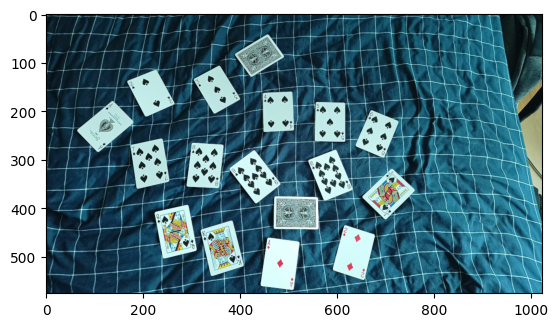

In [14]:
img = cv.imread("../assets/sample/cardset1.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)

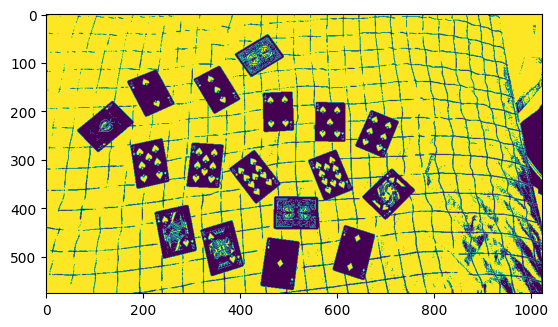

In [245]:
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
plt.imshow(thresh)

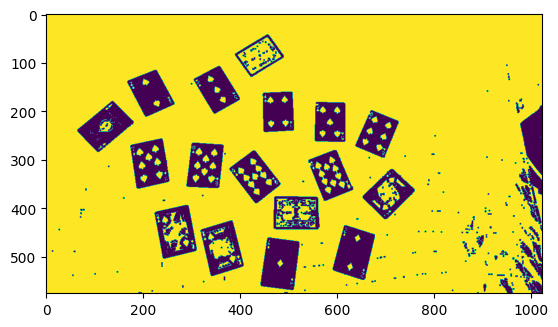

In [264]:
thresh_p = cv.morphologyEx(thresh, cv.MORPH_CLOSE, np.ones((3, 3), np.uint8))
for i in range(10):
    thresh_p = cv.morphologyEx(thresh_p, cv.MORPH_CLOSE, np.ones((3, 3), np.uint8))
plt.imshow(thresh_p)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.30it/s]


0.3139101556550199 40.99107353480137


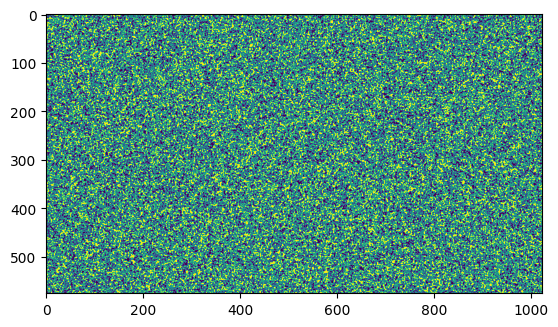

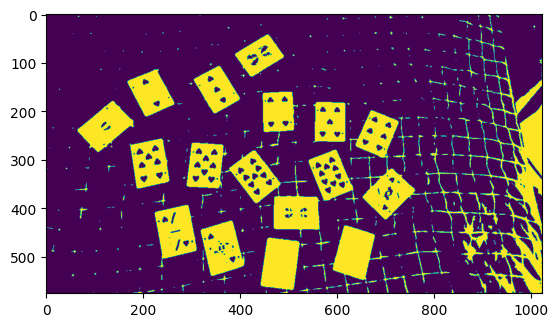

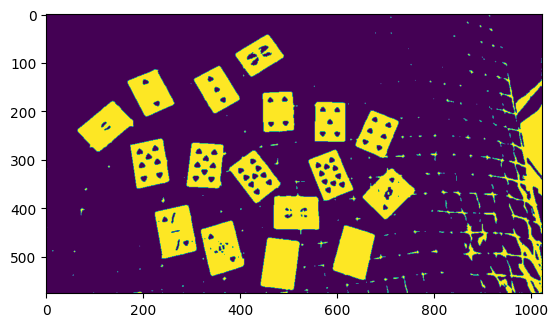

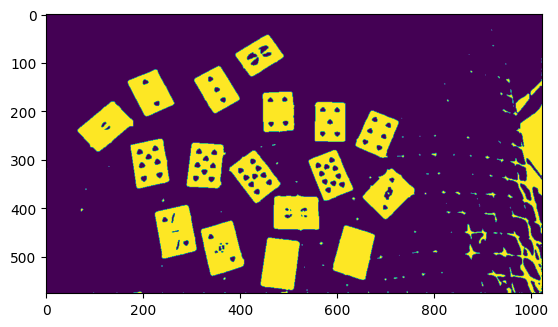

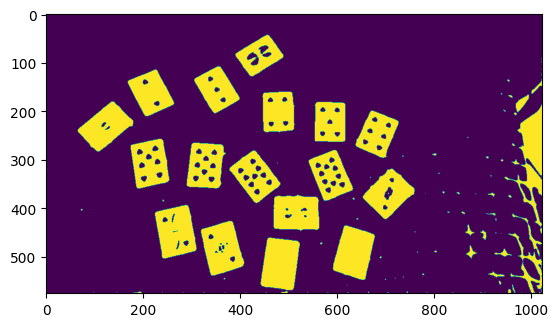

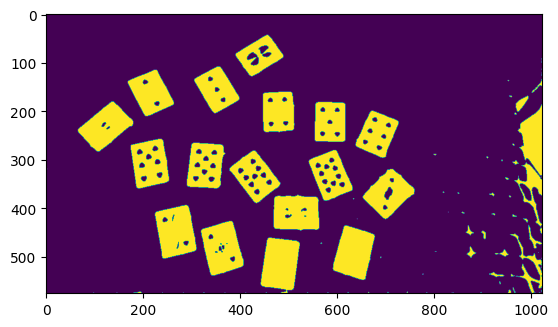

In [267]:
levelSet = np.random.uniform(-1, 1, img.shape[:-1])
for i in tqdm(range(50)):
    bgMean = img[levelSet>0].mean(axis=0)
    fgMean = img[levelSet<0].mean(axis=0)
    if np.sum(fgMean) < np.sum(bgMean):
        bgMean, fgMean = fgMean, bgMean
    colorGrad = -np.sqrt(np.sum(np.power(np.abs(img - bgMean), 2), axis=2))/255 + np.sqrt(np.sum(np.power(np.abs(img - fgMean), 2), axis=2))/255
    levelSet += 2*colorGrad  
    div = (levelSet[:-2, 1:-1] + levelSet[2:, 1:-1] + levelSet[1:-1, :-2] + levelSet[1:-1, 2:] - 4*levelSet[1:-1, 1:-1])/4
    levelSet += 1.0*np.pad(div, 1)
    if i % 10 == 0:
        plt.figure()
        plt.imshow(levelSet < 0)
    

plt.figure()
plt.imshow(levelSet < 0)
print(delta.mean(), levelSet.mean())

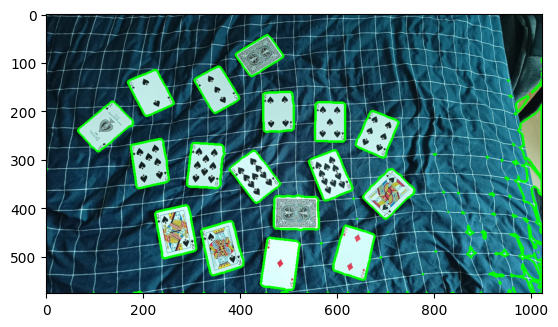

In [276]:
mask = levelSet < 0
contours, _ = cv.findContours(mask.astype('uint8'), cv.RETR_EXTERNAL , cv.CHAIN_APPROX_SIMPLE)

cimg = img.copy()
cv.drawContours(cimg, contours, -1, (0,255,0), 3)
plt.imshow(cimg)

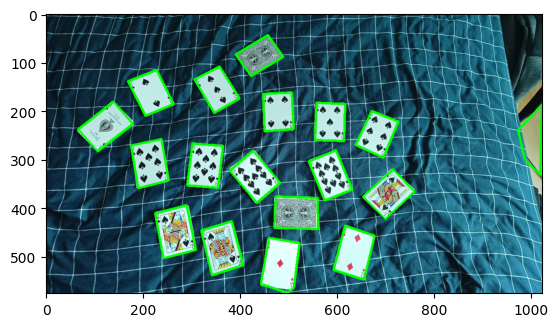

In [289]:
valid_contours = [cv.approxPolyDP(c, 10, True) for c in contours if cv.contourArea(c) > 3000]
cimg = img.copy()
cv.drawContours(cimg, valid_contours, -1, (0,255,0), 3)
plt.imshow(cimg)

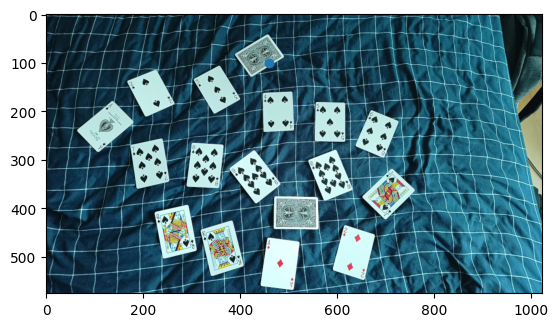

In [300]:
plt.imshow(img)
plt.scatter([460], [100])

In [291]:
valid_contours

[array([[[460, 462]],
 
        [[443, 557]],
 
        [[498, 575]],
 
        [[511, 565]],
 
        [[523, 473]]], dtype=int32),
 array([[[617, 437]],
 
        [[593, 528]],
 
        [[656, 548]],
 
        [[678, 458]]], dtype=int32),
 array([[[383, 428]],
 
        [[320, 447]],
 
        [[342, 539]],
 
        [[407, 518]]], dtype=int32),
 array([[[290, 395]],
 
        [[225, 412]],
 
        [[242, 504]],
 
        [[309, 487]]], dtype=int32),
 array([[[560, 380]],
 
        [[474, 377]],
 
        [[471, 441]],
 
        [[561, 444]]], dtype=int32),
 array([[[716, 321]],
 
        [[654, 377]],
 
        [[700, 423]],
 
        [[760, 367]]], dtype=int32),
 array([[[427, 283]],
 
        [[379, 324]],
 
        [[435, 390]],
 
        [[483, 349]]], dtype=int32),
 array([[[598, 282]],
 
        [[542, 305]],
 
        [[575, 385]],
 
        [[632, 363]]], dtype=int32),
 array([[[302, 268]],
 
        [[291, 354]],
 
        [[355, 359]],
 
        [[365, 273]]], dtype=int

In [338]:
coco = {
    "info": {
        "year": 2023,
        "version": "0.1",
        "description": "playing card (Bicycle Rider Black) on uniform background with mask",
        "contributor": "Pipat Saengow",
        "url": "",
        "date_created": "2023/05/20",
    },
    "licenses": [],
    "images": [
        {
                "file_name": "cardset1.jpg",
                "height": img.shape[0],
                "width": img.shape[1],
                "id": 397133
        }
    ],
    "categories": [
        {"supercategory": "cards","id": 1,"name": "card"},
    ],
    "annotations": [
        {
            "segmentation": [c.reshape(-1).tolist()],
            "area": cv.contourArea(ct),
            "iscrowd": 0,
            "image_id": 397133,
            "bbox": [int(x) for x in [np.min(c[:, 0]), np.min(c[:, 1]), np.max(c[:, 0]) - np.min(c[:, 0]), np.max(c[:, 1]) - np.min(c[:, 1])]],
            "category_id": 1,
            "id": 2222,
        } for (ct, c) in [(x, x[:, 0, :]) for x in valid_contours]
    ]
}

In [340]:
import json
with open("test_coco.json", "w") as f:
    json.dump(coco, f)
coco

{'info': {'year': 2023,
  'version': '0.1',
  'description': 'playing card (Bicycle Rider Black) on uniform background with mask',
  'contributor': 'Pipat Saengow',
  'url': '',
  'date_created': '2023/05/20'},
 'licenses': [],
 'images': [{'file_name': 'cardset1.jpg',
   'height': 576,
   'width': 1024,
   'id': 397133}],
 'categories': [{'supercategory': 'cards', 'id': 1, 'name': 'card'}],
 'annotations': [{'segmentation': [[460,
     462,
     443,
     557,
     498,
     575,
     511,
     565,
     523,
     473]],
   'area': 6654.0,
   'iscrowd': 0,
   'image_id': 397133,
   'bbox': [443, 462, 80, 113],
   'category_id': 1,
   'id': 2222},
  {'segmentation': [[617, 437, 593, 528, 656, 548, 678, 458]],
   'area': 6082.5,
   'iscrowd': 0,
   'image_id': 397133,
   'bbox': [593, 437, 85, 111],
   'category_id': 1,
   'id': 2222},
  {'segmentation': [[383, 428, 320, 447, 342, 539, 407, 518]],
   'area': 6284.0,
   'iscrowd': 0,
   'image_id': 397133,
   'bbox': [320, 428, 87, 111],